In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import cv2

import open3d as o3

from sklearn.model_selection import train_test_split
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

In [3]:
clip180 = partial(np.clip, a_min=-3.14, a_max=3.14)
clip90 = partial(np.clip, a_min=0., a_max=1.57)

In [4]:
def getCore(data):
    coreTmp = np.zeros((1, 3))
    coreTmp[:, 0] = np.sum(data[:, ::3], axis=1) / (data.shape[1] / 3)   #coreX
    coreTmp[:, 1] = np.sum(data[:, 1::3], axis=1) / (data.shape[1] / 3)  #coreY
    coreTmp[:, 2] = np.sum(data[:, 2::3], axis=1) / (data.shape[1] / 3)  #coreZ

    return coreTmp


def dataShift(data, core):    #使全部點剛好在第一象限
    data[:, ::3] = data[:, ::3] - core[0, 0]
    data[:, 1::3] = data[:, 1::3] - core[0, 1]
    data[:, 2::3] = data[:, 2::3] - core[0, 2]

    xShiftTmp = min(data[0, ::3])
    yShiftTmp = min(data[0, 1::3])
    zShiftTmp = min(data[0, 2::3])

    data[:, ::3] = data[:, ::3] - xShiftTmp
    data[:, 1::3] = data[:, 1::3] - yShiftTmp
    data[:, 2::3] = data[:, 2::3] - zShiftTmp

    return data


def getMaxRadius(data):
    maxTmp = 0
    indexTmp = 0

    for i in range(data.shape[1] // 3):
        tmp = np.sqrt(np.square(data[0, i*3]) + np.square(data[0, i*3 + 1]) + np.square(data[0, i*3 + 2]))
        if (tmp  > maxTmp):
            maxTmp = tmp
            indexTmp = i    

    return indexTmp, maxTmp


def getAABBSize(rdata):  
    xTmp = rdata[0, ::3]
    yTmp = rdata[0, 1::3]
    zTmp = rdata[0, 2::3]

    xDis = max(xTmp) - min(xTmp)
    yDis = max(yTmp) - min(yTmp)
    zDis = max(zTmp) - min(zTmp) 

    return xDis, yDis, zDis


def get3DMatrix(xDis, yDis, zDis, rData):
    MCount = np.zeros((mSize, mSize, mSize))
    MCount = MCount + 1e-7    #避免除零    
    MResult = np.zeros((mSize, mSize, mSize * 3))    #三通道
    MXSum = np.zeros((mSize, mSize, mSize))
    MYSum = np.zeros((mSize, mSize, mSize))
    MZSum = np.zeros((mSize, mSize, mSize))

    for i in range (rData.shape[1] // 3):
        D1Tmp = math.floor(rData[0, i*3] / xDis * mSize)
        D2Tmp = math.floor(rData[0, i*3 + 1] / yDis * mSize)
        D3Tmp = math.floor(rData[0, i*3 + 2] / zDis * mSize)
        
        D1Tmp = np.minimum(12, D1Tmp)
        D2Tmp = np.minimum(12, D2Tmp)
        D3Tmp = np.minimum(12, D3Tmp)
        
        D1Tmp = np.maximum(-12, D1Tmp)
        D2Tmp = np.maximum(-12, D2Tmp)
        D3Tmp = np.maximum(-12, D3Tmp)

        if D1Tmp != mSize and D2Tmp != mSize and D3Tmp != mSize:
            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
        else:
            D1Tmp = D1Tmp - 1 if D1Tmp == mSize else D1Tmp
            D2Tmp = D2Tmp - 1 if D2Tmp == mSize else D2Tmp
            D3Tmp = D3Tmp - 1 if D3Tmp == mSize else D3Tmp

            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
            
    MXSum = np.divide(MXSum, MCount)
    MYSum = np.divide(MYSum, MCount)
    MZSum = np.divide(MZSum, MCount)

    for i in range(mSize):
        MResult[:, :, i * 3] = MXSum[:, :, i]
        MResult[:, :, i * 3 + 1] = MYSum[:, :, i]
        MResult[:, :, i * 3 + 2] = MZSum[:, :, i]

    return MResult    

In [5]:
def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])


def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

In [6]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [7]:
def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [9]:
def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

In [10]:
TRAIN_QUANTITY = 10
TEST_QUANTITY = 10
mSize = 12

In [11]:
def get_files_names(path):
    fnames=[]
    for idx, name in enumerate(path.ls()):
        if name.suffix == '.ply':
            fnames.append(name)
    return fnames

## Read whole point clouds

In [13]:
w_voxel_size = 0.000012
w_pcd = o3.read_point_cloud('Datasets_Generator/pcd/pipe.pcd')
print(w_pcd)
w_downpcd = o3.voxel_down_sample(w_pcd, voxel_size=w_voxel_size)
print(w_downpcd)

geometry::PointCloud with 11412 points.
geometry::PointCloud with 1900 points.


In [18]:
o3.visualization.draw_geometries([w_pcd])

In [14]:
o3.visualization.draw_geometries([w_downpcd])

## Read partial point clouds

In [15]:
p_voxel_size = 0.0075
p_pcd = o3.read_point_cloud('Datasets_Generator/pcd/pip3.pcd')
print(p_pcd)
p_downpcd = o3.voxel_down_sample(p_pcd, voxel_size=p_voxel_size)
print(p_downpcd)

geometry::PointCloud with 11622 points.
geometry::PointCloud with 1935 points.


In [19]:
o3.visualization.draw_geometries([p_pcd])

In [20]:
o3.visualization.draw_geometries([p_downpcd])

In [21]:
# test_p_pcd = np.asarray(p_downpcd.points)
# test_w_pcd = np.asarray(w_downpcd.points)

test_p_pcd = np.asarray(p_pcd.points)
test_w_pcd = np.asarray(w_pcd.points)

In [22]:
test_p_pcd.shape

(11622, 3)

In [35]:
starttime = datetime.datetime.now()

data = np.asarray(p_downpcd.points) 
w_data = np.asarray(w_downpcd.points) 


train_raw = []
test_raw = []

w_train_raw =[]
w_test_raw = []

for i in range(TRAIN_QUANTITY + TEST_QUANTITY):
    q = np.random.uniform(0., 1., (3))        
    q = np.append(q, 0.)

    labels = q
    
    rotateData = np.zeros(data.shape)
    w_rotateData = np.zeros(w_data.shape)
    
    for n in range(data.shape[0]):
        rotateData[n] = rotate_with_q(data[n], q)

    for n in range(w_data.shape[0]):
        w_rotateData[n] = rotate_with_q(w_data[n], q)

    rotateData = rotateData.reshape(1, -1)
    w_rotateData = w_rotateData.reshape(1, -1)
    
    # core = getCore(rotateData)
    # rotateData = dataShift(rotateData, core).reshape(1, -1)       
    dis = getAABBSize(rotateData)
    w_dis = getAABBSize(w_rotateData)

    
    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)
    w_result = get3DMatrix(w_dis[0], w_dis[1], w_dis[2], w_rotateData).reshape(-1)

    tmp1 = np.hstack([result, labels])
    w_tmp1 = np.hstack([w_result, labels])

    if i < TRAIN_QUANTITY:
        train_raw.append(tmp1.tolist())
        w_train_raw.append(w_tmp1.tolist())
    else:
        if i == TRAIN_QUANTITY:
            np.savetxt('Gan_datasets/p_bunny_train_Quaternion.txt', 
                        np.array(train_raw))
            print('p_bunny_Quaternion.txt')
            train_raw = np.array(train_raw)
            gc.collect()

            np.savetxt('Gan_datasets/w_bunny_train_Quaternion.txt', 
                        np.array(w_train_raw))
            print('w_bunny_Quaternion.txt')
            w_train_raw = np.array(w_train_raw)
            gc.collect()
            

        test_raw.append(tmp1.tolist())
        w_test_raw.append(w_tmp1.tolist())


    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))


np.savetxt('Gan_datasets/p_bunny_test_Quaternion.txt', 
        np.array(test_raw))
print('p_bunny_Quaternion.txt')
test_raw = np.array(test_raw)
gc.collect()

np.savetxt('Gan_datasets/w_bunny_test_Quaternion.txt', 
        np.array(w_test_raw))
print('w_bunny_Quaternion.txt')
w_test_raw = np.array(w_test_raw)
gc.collect()

endtime = datetime.datetime.now()        
print ("Total execute time: " + str(endtime - starttime))     

item 0 execute time: 0:00:00.093730
p_bunny_Quaternion.txt
w_bunny_Quaternion.txt
p_bunny_Quaternion.txt
w_bunny_Quaternion.txt
Total execute time: 0:00:02.425168


## Test the generated datas

In [36]:
train_raw.shape

(10, 5188)

In [37]:
w_train_raw.shape

(10, 5188)

## Separate the labels

In [38]:
def seperate_labels(data, dev_set=True, delete_data=True):
    # assert (data.shape[1] - 3) % 3 == 0
    mSize = 12

    if dev_set == False:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_data, y_data

    else:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_data, y_data, test_size=0.1, random_state=1)
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_train, x_dev, y_train, y_dev

In [39]:
x_train, x_dev, y_train, y_dev = seperate_labels(train_raw)

In [40]:
xw_train, xw_dev, yw_train, yw_dev = seperate_labels(w_train_raw)

In [41]:
xt_train, xt_dev, yt_train, yt_dev = seperate_labels(test_raw)

In [42]:
xwt_train, xwt_dev, ywt_train, ywt_dev = seperate_labels(w_test_raw)

In [43]:
x_train.shape, x_dev.shape, xw_train.shape, xw_dev.shape

((9, 12, 12, 12, 3),
 (1, 12, 12, 12, 3),
 (9, 12, 12, 12, 3),
 (1, 12, 12, 12, 3))

In [44]:
np.max(x_train), np.min(x_train), np.max(xw_train), np.min(xw_train)

(0.18382262047383233,
 -0.1714617145963312,
 121.43593300746568,
 -118.49518031725148)

In [45]:
random_pcd = x_train[5]

In [46]:
random_pcd.shape

(12, 12, 12, 3)

In [47]:
random_pcd = random_pcd.reshape(-1, 3) # get the points from mesh

np.savetxt("random_pcd.txt", random_pcd) # save files for txt (.stem means to clear the semifiles) 
pcd = o3.read_point_cloud("random_pcd.txt", format='xyz') 
o3.visualization.draw_geometries([pcd])

In [48]:
o3.visualization.draw_geometries([pcd])

Text(0.5, 0.92, 'original')

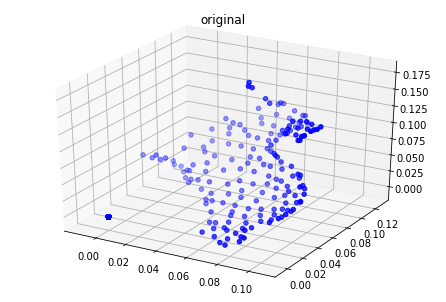

In [49]:
fig = plt.figure()
ax = Axes3D(fig)

x_test_sample = x_train[5].reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('original')

Text(0.5, 0.92, 'original')

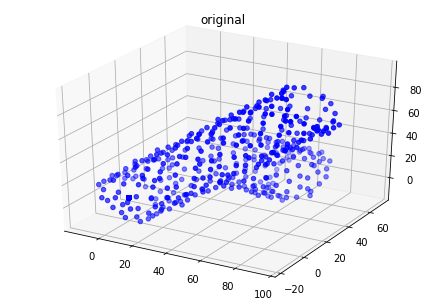

In [50]:
fig = plt.figure()
ax = Axes3D(fig)

x_test_sample = xw_train[5].reshape(-1, 3)
x = x_test_sample[:, 0]
y = x_test_sample[:, 1]
z = x_test_sample[:, 2]
ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('original')

In [51]:
np.savetxt('Gan_datasets/gw_bunny_train_Quaternion.txt', 
                        np.array(xw_train.reshape(xw_train.shape[0], 5184)))

In [52]:
np.savetxt('Gan_datasets/gp_bunny_train_Quaternion.txt', 
                        np.array(x_train.reshape(x_train.shape[0], 5184)))

In [53]:
np.savetxt('Gan_datasets/gw_bunny_dev_Quaternion.txt', 
                        np.array(xw_dev.reshape(xw_dev.shape[0], 5184)))

In [54]:
np.savetxt('Gan_datasets/gp_bunny_dev_Quaternion.txt', 
                        np.array(x_dev.reshape(x_dev.shape[0], 5184)))